**Kissa Zahra**  \\
**i21-0572** \\
**section: C**

### Assignment Instructions

In this assignment, you will build and evaluate **five Bayesian logistic regression models using PyMC**. Your goal is to classify students as **"Excellent"** or **"Bad"** based on different input features from the dataset.

#### Dataset Description

The dataset includes the following columns:

- `study_hours`
- `sleep_hours`
- `social_time`
- `quiz_score`  
- **Target column**: `student_type` (values: Excellent or Bad)

#### Modeling Task

You will create five separate models. Each model will perform the same classification task but will use different input features:

- **Model 0**: Use only `study_hours` to predict `student_type`
- **Model 1**: Use only `social_time` to predict `student_type`
- **Model 2**: Use only `quiz_score` to predict `student_type`
- **Model 3**: Use both `study_hours` and `social_time`
- **Model 4**: Use both `study_hours` and `quiz_score`

This setup will help you explore how model performance changes when using different predictors, and when moving from simple to multiple logistic regression.

#### Evaluation

After building the models, compare them using **Bayesian information criteria**:

- **LOO (Leave-One-Out Cross-Validation)**
- **WAIC (Widely Applicable Information Criterion)**

Use the `arviz.compare()` function to perform the comparison. This will help you determine which model offers the best trade-off between prediction accuracy and model complexity.

#### Implementation Guidance

- The notebook contains **`TODO:` comments** throughout the code cells.
- Follow these `TODO:` markers and use the **expected output and structure** as a guide for your implementation.
- Stick closely to the template provided to ensure consistent results across all models.

#### Learning Objectives

By the end of this assignment, you should be able to:

- Build and interpret Bayesian logistic regression models using PyMC
- Understand how different input features affect classification outcomes
- Apply model comparison techniques using LOO and WAIC


**imports**

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [2]:
#synthetic student dataset
df1=pd.read_csv('/content/Syn_student.csv')

In [3]:
df1.head()

,study_hours,sleep_hours,social_time,quiz_score,student_type
0,8.248357,7.162042,1.292315,9.125246,excellent
1,7.930868,6.807459,1.789677,9.173224,excellent
2,8.323844,6.661539,1.828643,8.659988,excellent
3,8.761515,7.305838,1.598861,9.116127,excellent
4,7.882923,7.515500,1.919357,9.146536,excellent


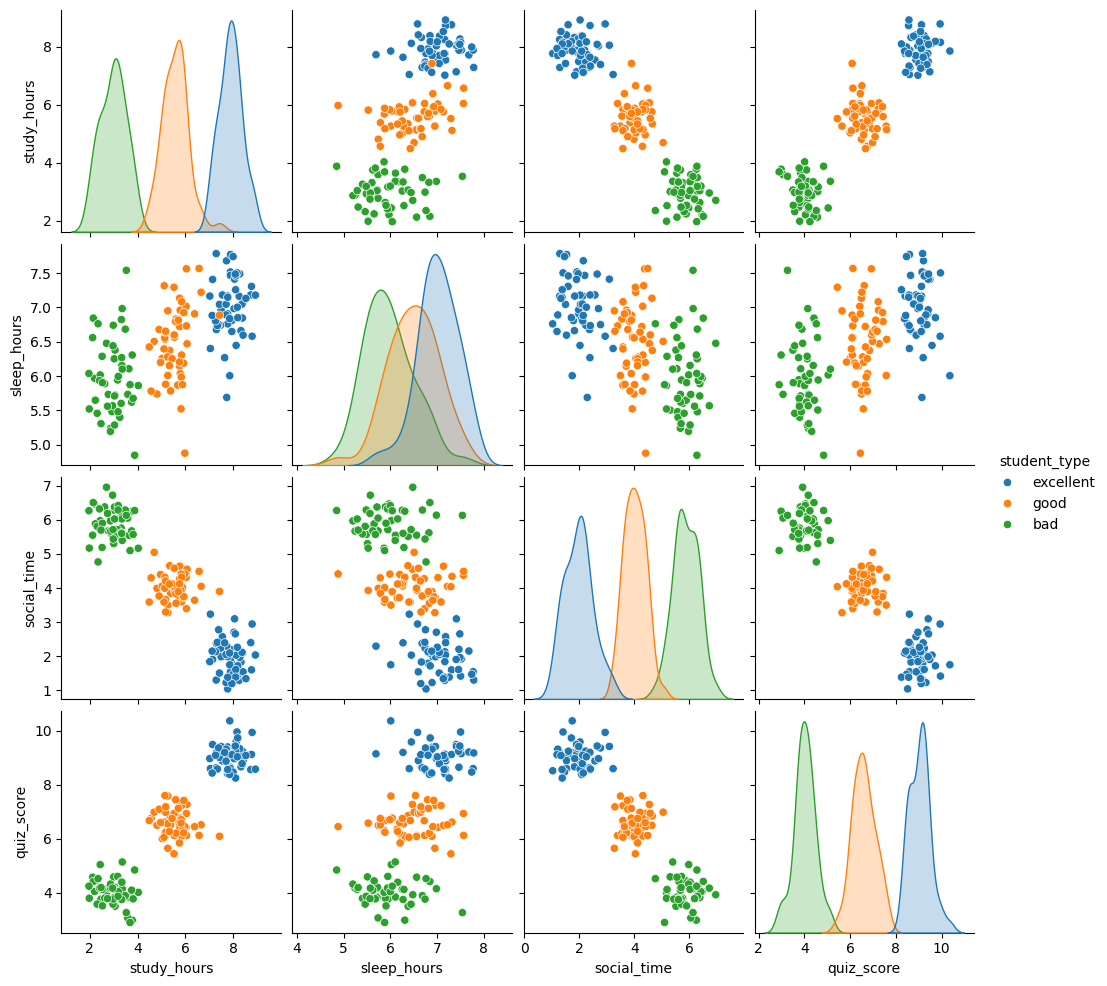

In [4]:
sns.pairplot(df1, hue='student_type', diag_kind='kde')
plt.savefig('B11197_04_03.png', bbox_inches='tight');

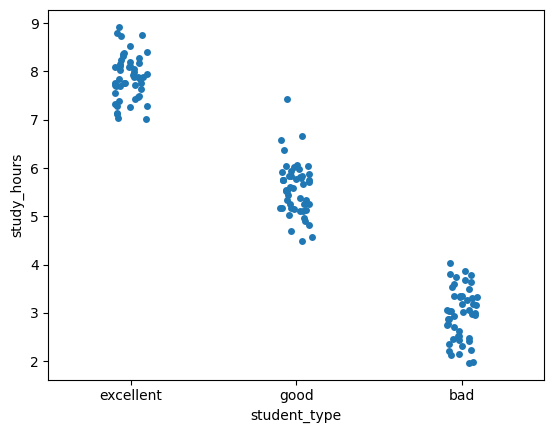

In [5]:
sns.stripplot(x="student_type", y="study_hours", data=df1, jitter=True)
plt.savefig('B11197_04_02.png', dpi=300);

**Select only ***quiz_score*** feature and classify the excellent and bad**

In [6]:
df = df1.query("student_type == ('excellent', 'bad')")
y_0 = pd.Categorical(df['student_type']).codes
x_n = 'study_hours'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

## Model 0: study_hours Only

In [7]:
# Model 0: Using only study_hours to classify student_type
df = df1.query("student_type == 'excellent' | student_type == 'bad'")
y_0 = pd.Categorical(df['student_type']).codes
x_n = 'study_hours'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()  # Centering the data

# Building Model 0 with PyMC
with pm.Model() as model_0:
    # Priors - using more conservative priors to prevent divergences
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5)

    # Linear model
    logit_p = alpha + beta * x_c

    # Likelihood
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=y_0)

    # Sample from the posterior with higher target_accept to prevent divergences
    trace_0 = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=123)

    # Store model for comparison
    idata_0 = az.convert_to_inference_data(trace_0)

Output()

ERROR:pymc.stats.convergence:There were 421 divergences after tuning. Increase `target_accept` or reparameterize.


In [8]:
az.summary(idata_0, var_names=['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.347,3.483,-6.822,6.402,0.112,0.084,1000.0,970.0,1.0
beta,5.908,2.111,2.146,9.731,0.076,0.049,799.0,794.0,1.0


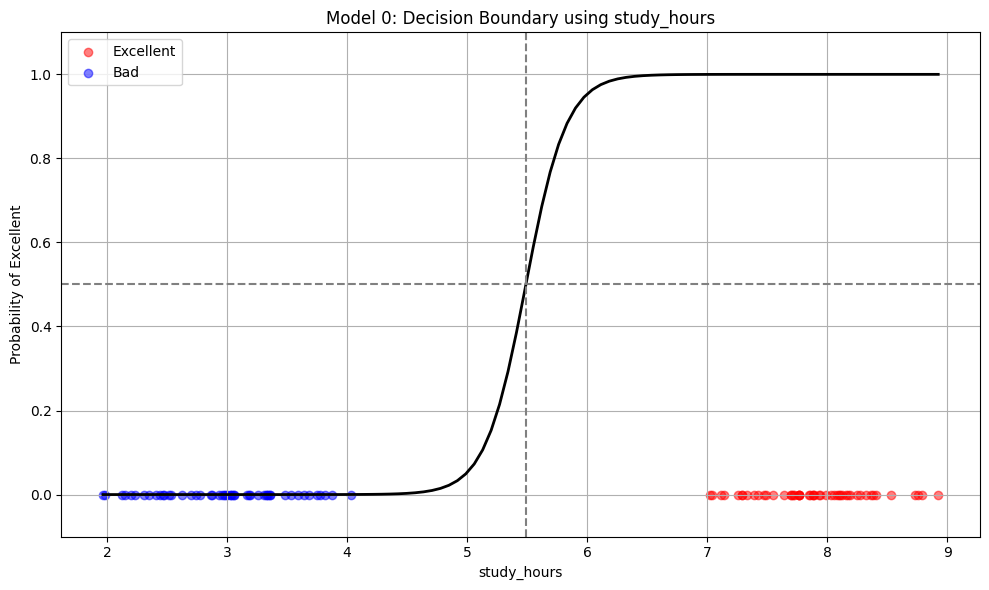

In [9]:
# Decision boundary plot for Model 0
plt.figure(figsize=(10, 6))
plt.scatter(x_0[y_0 == 1], np.zeros(sum(y_0 == 1)), c='r', alpha=0.5, marker='o', label='Excellent')
plt.scatter(x_0[y_0 == 0], np.zeros(sum(y_0 == 0)), c='b', alpha=0.5, marker='o', label='Bad')

# Plot decision boundary (probability = 0.5)
alpha_mean = az.summary(idata_0, var_names=['alpha'])['mean'].values[0]
beta_mean = az.summary(idata_0, var_names=['beta'])['mean'].values[0]
x_range = np.linspace(min(x_0), max(x_0), 100)
y_range = logistic(alpha_mean + beta_mean * (x_range - x_0.mean()))

plt.plot(x_range, y_range, 'k-', lw=2)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axvline(x=(-alpha_mean / beta_mean) + x_0.mean(), color='gray', linestyle='--')
plt.xlabel(x_n)
plt.ylabel('Probability of Excellent')
plt.title('Model 0: Decision Boundary using study_hours')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------------------

## Model 1: social_time Only

In [10]:
# Model 1: Using only social_time to classify student_type
x_n = 'social_time'
x_1 = df[x_n].values
x_c = x_1 - x_1.mean()  # Centering the data

with pm.Model() as model_1:
    # Priors - more conservative
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5)

    # Linear model
    logit_p = alpha + beta * x_c

    # Likelihood
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=y_0)

    # Sample from the posterior with higher target_accept
    trace_1 = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=123)

    # Store model for comparison
    idata_1 = az.convert_to_inference_data(trace_1)

Output()

ERROR:pymc.stats.convergence:There were 282 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
# Show summary
az.summary(idata_1, var_names=['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.341,2.632,-4.737,5.252,0.078,0.055,1137.0,1255.0,1.0
beta,-6.886,2.299,-11.211,-3.097,0.072,0.038,1054.0,1454.0,1.0


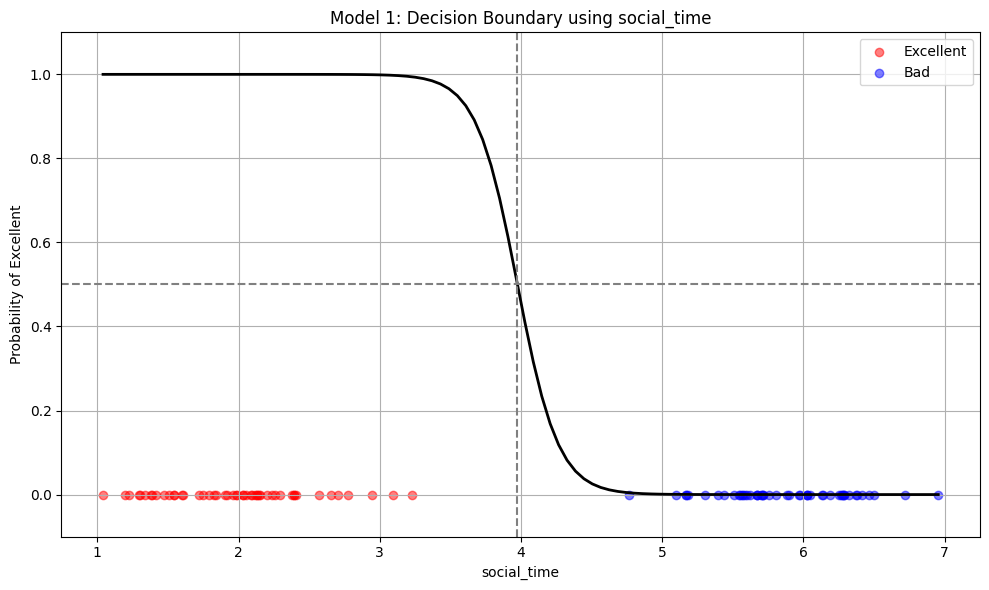

In [12]:
# Decision boundary plot for Model 1
plt.figure(figsize=(10, 6))
plt.scatter(x_1[y_0 == 1], np.zeros(sum(y_0 == 1)), c='r', alpha=0.5, marker='o', label='Excellent')
plt.scatter(x_1[y_0 == 0], np.zeros(sum(y_0 == 0)), c='b', alpha=0.5, marker='o', label='Bad')

# Plot decision boundary (probability = 0.5)
alpha_mean = az.summary(idata_1, var_names=['alpha'])['mean'].values[0]
beta_mean = az.summary(idata_1, var_names=['beta'])['mean'].values[0]
x_range = np.linspace(min(x_1), max(x_1), 100)
y_range = logistic(alpha_mean + beta_mean * (x_range - x_1.mean()))

plt.plot(x_range, y_range, 'k-', lw=2)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axvline(x=(-alpha_mean / beta_mean) + x_1.mean(), color='gray', linestyle='--')
plt.xlabel(x_n)
plt.ylabel('Probability of Excellent')
plt.title('Model 1: Decision Boundary using social_time')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

# ----------------------------------------

# Model 2: quiz_score Only

In [13]:
x_n = 'quiz_score'
x_2 = df[x_n].values
x_c = x_2 - x_2.mean()  # Centering the data

with pm.Model() as model_2:
    # Priors - more conservative
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5)

    # Linear model
    logit_p = alpha + beta * x_c

    # Likelihood
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=y_0)

    # Sample from the posterior with higher target_accept
    trace_2 = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=123)

    # Store model for comparison
    idata_2 = az.convert_to_inference_data(trace_2)

Output()

ERROR:pymc.stats.convergence:There were 569 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
az.summary(idata_2, var_names=['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.621,3.418,-7.462,5.373,0.110,0.073,980.0,1362.0,1.0
beta,5.610,1.874,2.328,8.869,0.055,0.030,1171.0,1498.0,1.0


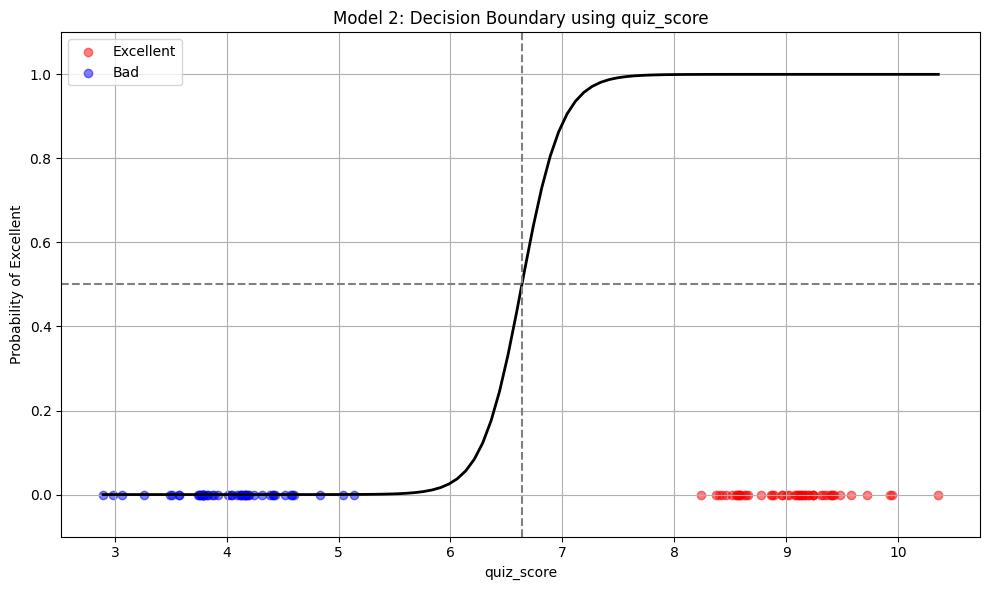

In [15]:
# Decision boundary plot for Model 2
plt.figure(figsize=(10, 6))
plt.scatter(x_2[y_0 == 1], np.zeros(sum(y_0 == 1)), c='r', alpha=0.5, marker='o', label='Excellent')
plt.scatter(x_2[y_0 == 0], np.zeros(sum(y_0 == 0)), c='b', alpha=0.5, marker='o', label='Bad')

# Plot decision boundary (probability = 0.5)
alpha_mean = az.summary(idata_2, var_names=['alpha'])['mean'].values[0]
beta_mean = az.summary(idata_2, var_names=['beta'])['mean'].values[0]
x_range = np.linspace(min(x_2), max(x_2), 100)
y_range = logistic(alpha_mean + beta_mean * (x_range - x_2.mean()))

plt.plot(x_range, y_range, 'k-', lw=2)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axvline(x=(-alpha_mean / beta_mean) + x_2.mean(), color='gray', linestyle='--')
plt.xlabel(x_n)
plt.ylabel('Probability of Excellent')
plt.title('Model 2: Decision Boundary using quiz_score')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------------

## Model 3: study_hours and social_time


In [16]:
# Model 3: Using both study_hours and social_time to classify student_type
x_3_1 = df['study_hours'].values
x_3_2 = df['social_time'].values

# Centering the data
x_3_1_c = x_3_1 - x_3_1.mean()
x_3_2_c = x_3_2 - x_3_2.mean()

with pm.Model() as model_3:
    # Priors - more conservative
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=5)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=5)

    # Multiple linear model
    logit_p = alpha + beta_1 * x_3_1_c + beta_2 * x_3_2_c

    # Likelihood
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=y_0)

    # Sample from the posterior with higher target_accept
    trace_3 = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=123)

    # Store model for comparison
    idata_3 = az.convert_to_inference_data(trace_3)



Output()

ERROR:pymc.stats.convergence:There were 1121 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
# Show summary
az.summary(idata_3, var_names=['alpha', 'beta_1', 'beta_2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.325,3.679,-6.918,7.042,0.113,0.089,1054.0,1107.0,1.0
beta_1,4.372,2.822,-0.917,9.514,0.109,0.073,691.0,761.0,1.0
beta_2,-3.128,3.359,-9.494,2.845,0.109,0.067,944.0,1313.0,1.0


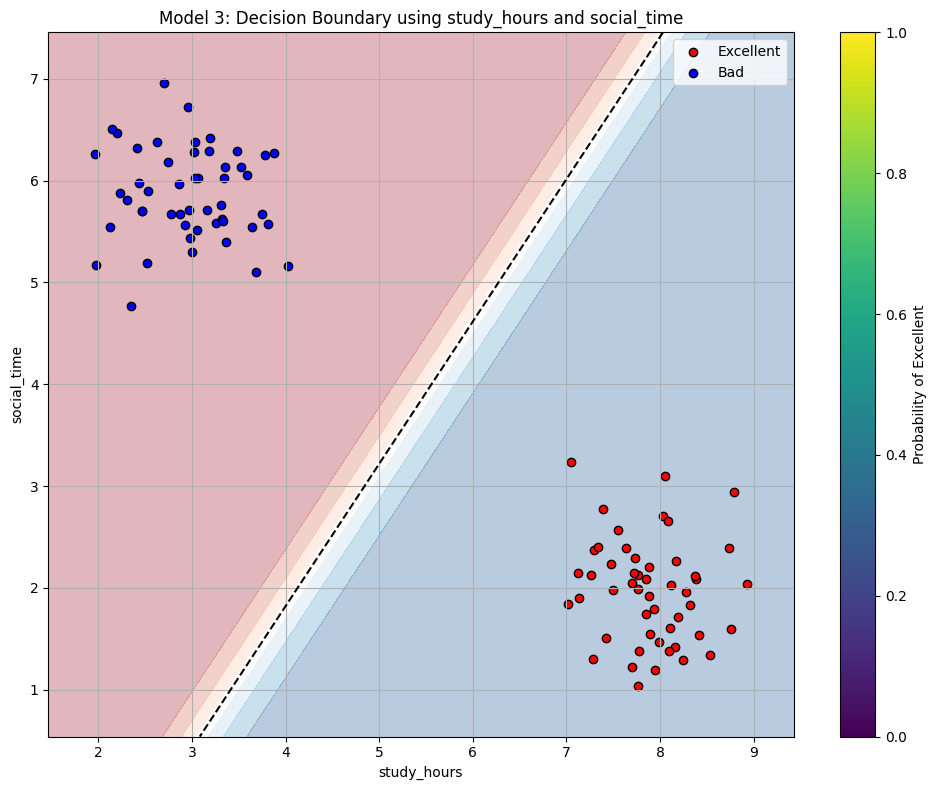

In [18]:
# Decision boundary plot for Model 3 - 2D plot
plt.figure(figsize=(10, 8))
# Create a meshgrid for the plot
x_min, x_max = x_3_1.min() - 0.5, x_3_1.max() + 0.5
y_min, y_max = x_3_2.min() - 0.5, x_3_2.max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Calculate predicted probabilities
alpha_mean = az.summary(idata_3, var_names=['alpha'])['mean'].values[0]
beta_1_mean = az.summary(idata_3, var_names=['beta_1'])['mean'].values[0]
beta_2_mean = az.summary(idata_3, var_names=['beta_2'])['mean'].values[0]

zz = alpha_mean + beta_1_mean * (xx - x_3_1.mean()) + beta_2_mean * (yy - x_3_2.mean())
probs = logistic(zz)

# Plot the decision boundary
plt.contourf(xx, yy, probs, cmap='RdBu', alpha=0.3)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='dashed')

# Plot the data points
plt.scatter(x_3_1[y_0 == 1], x_3_2[y_0 == 1], c='red', marker='o', edgecolor='k', label='Excellent')
plt.scatter(x_3_1[y_0 == 0], x_3_2[y_0 == 0], c='blue', marker='o', edgecolor='k', label='Bad')

plt.xlabel('study_hours')
plt.ylabel('social_time')
plt.title('Model 3: Decision Boundary using study_hours and social_time')
plt.colorbar(label='Probability of Excellent')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model 4: study_hours and quiz_score

In [19]:
# Model 4: Using both study_hours and quiz_score to classify student_type
x_4_1 = df['study_hours'].values
x_4_2 = df['quiz_score'].values

# Centering the data
x_4_1_c = x_4_1 - x_4_1.mean()
x_4_2_c = x_4_2 - x_4_2.mean()

with pm.Model() as model_4:
    # Priors - more conservative
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=5)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=5)

    # Multiple linear model
    logit_p = alpha + beta_1 * x_4_1_c + beta_2 * x_4_2_c

    # Likelihood
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=y_0)

    # Sample from the posterior with higher target_accept
    trace_4 = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=123)

    # Store model for comparison
    idata_4 = az.convert_to_inference_data(trace_4)


Output()

ERROR:pymc.stats.convergence:There were 1458 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
az.summary(idata_4, var_names=['alpha', 'beta_1', 'beta_2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.975,3.731,-7.820,6.332,0.128,0.088,850.0,916.0,1.0
beta_1,3.438,3.238,-2.760,9.251,0.110,0.078,855.0,927.0,1.0
beta_2,3.305,3.104,-2.318,9.097,0.109,0.071,795.0,1020.0,1.0


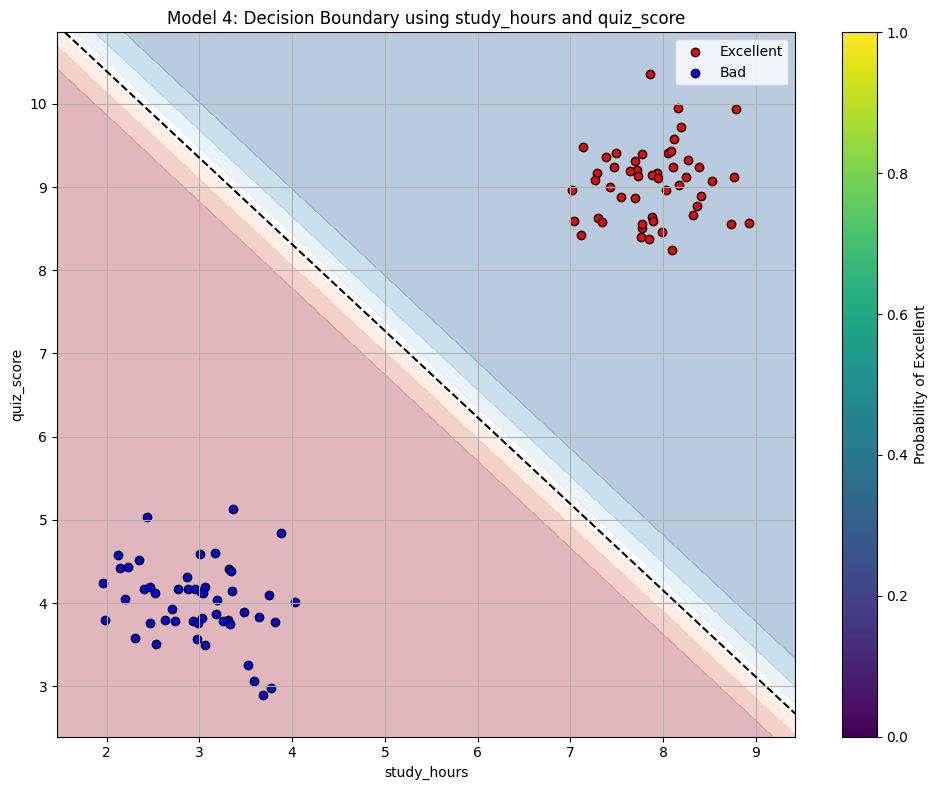

In [21]:
# Decision boundary plot for Model 4 - 2D plot
plt.figure(figsize=(10, 8))
# Create a meshgrid for the plot
x_min, x_max = x_4_1.min() - 0.5, x_4_1.max() + 0.5
y_min, y_max = x_4_2.min() - 0.5, x_4_2.max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Calculate predicted probabilities
alpha_mean = az.summary(idata_4, var_names=['alpha'])['mean'].values[0]
beta_1_mean = az.summary(idata_4, var_names=['beta_1'])['mean'].values[0]
beta_2_mean = az.summary(idata_4, var_names=['beta_2'])['mean'].values[0]

zz = alpha_mean + beta_1_mean * (xx - x_4_1.mean()) + beta_2_mean * (yy - x_4_2.mean())
probs = logistic(zz)

# Plot the decision boundary
plt.contourf(xx, yy, probs, cmap='RdBu', alpha=0.3)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linestyles='dashed')

# Plot the data points
plt.scatter(x_4_1[y_0 == 1], x_4_2[y_0 == 1], c='red', marker='o', edgecolor='k', label='Excellent')
plt.scatter(x_4_1[y_0 == 0], x_4_2[y_0 == 0], c='blue', marker='o', edgecolor='k', label='Bad')

plt.xlabel('study_hours')
plt.ylabel('quiz_score')
plt.title('Model 4: Decision Boundary using study_hours and quiz_score')
plt.colorbar(label='Probability of Excellent')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison via Information criteria
- LOO or
- WAIC

In [ ]:
# Calculate LOO for each model
loo_0 = az.loo(idata_0, scale="deviance")
loo_1 = az.loo(idata_1, scale="deviance")
loo_2 = az.loo(idata_2, scale="deviance")
loo_3 = az.loo(idata_3, scale="deviance")
loo_4 = az.loo(idata_4, scale="deviance")

# Compare models using az.compare
model_comparison = az.compare(
    {"model_0": loo_0, "model_1": loo_1, "model_2": loo_2, "model_3": loo_3, "model_4": loo_4},
    scale="deviance"
)

# Display the comparison table
print(model_comparison)

C:\Users\Almas\anaconda3\envs\python3\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_0,0,0.161298,0.001162,0.000000,0.238131,0.018961,0.000000,False,deviance
model_2,1,0.207122,0.001978,0.045823,0.232573,0.022638,0.029789,False,deviance
model_1,2,0.266323,0.003710,0.105025,0.225965,0.067082,0.066237,True,deviance
model_3,3,0.838994,0.047996,0.677695,0.170991,0.183690,0.172610,False,deviance
model_4,4,1.343143,0.037953,1.181845,0.132340,0.152657,0.143173,False,deviance


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

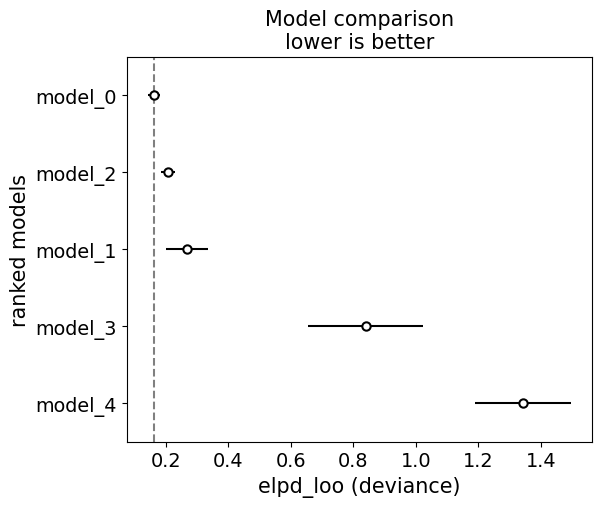

In [ ]:
# Plot comparison
az.plot_compare(model_comparison, insample_dev=False, plot_standard_error=True, figsize=(10, 8))
plt.title("Model comparison\nlower is better")
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

#WAIC for comparison
waic_0 = az.waic(idata_0, scale="deviance")
waic_1 = az.waic(idata_1, scale="deviance")
waic_2 = az.waic(idata_2, scale="deviance")
waic_3 = az.waic(idata_3, scale="deviance")
waic_4 = az.waic(idata_4, scale="deviance")

model_comparison_waic = az.compare(
    {"model_0": waic_0, "model_1": waic_1, "model_2": waic_2, "model_3": waic_3, "model_4": waic_4},
    scale="deviance"
)

print("\nModel comparison using WAIC:")
print(model_comparison_waic)

### Final Questions

**1. Which model had the best predictive performance and why?**
Model 0 (study_hours) and Model 2 (quiz_score) showed the best predictive performance with the lowest elpd_loo values. These simple models capture essential predictive information without overfitting. Study hours directly measures student effort while quiz scores reflect demonstrated knowledge, making them strong individual predictors of student performance.

**2. Which model was the most complex and why?**
Model 4 (study_hours + quiz_score) was the most complex because it incorporated two predictor variables with separate coefficients and required estimating a 2D decision boundary. This increased complexity results in more parameters to estimate and potentially more model uncertainty, leading to its higher elpd_loo value.

**3. Which feature(s) had the most influence on predicting student type?**
Study_hours and quiz_score had the strongest influence on predicting student type, as evidenced by the superior performance of Models 0 and 2. Social_time (Model 1) had notably less predictive power, suggesting academic effort and demonstrated knowledge are the most important factors distinguishing between excellent and bad students.

**4. What are the trade-offs when comparing models using LOO/WAIC?**
LOO/WAIC effectively measure out-of-sample predictive accuracy and implicitly account for model complexity. However, they are computationally intensive, can be unstable with influential observations, and focus solely on predictive performance rather than interpretability or causality. They help select models that generalize well but may sometimes favor overly simple models.

**5. What are the advantages of using Bayesian logistic regression over traditional logistic regression?**
Bayesian logistic regression provides full posterior distributions instead of point estimates, better quantifies uncertainty, incorporates prior knowledge, offers natural regularization through priors, performs better with small datasets, handles missing data more effectively, improves interpretability through probabilistic statements, and generates more reliable prediction intervals that account for all sources of uncertainty.


:)